In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import random
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 10 
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from sklearn import preprocessing
from statannot import add_stat_annotation
from scipy import optimize
from sklearn.mixture import GaussianMixture
import copy

# Functions

In [2]:
def algin_P_to_cas(data_cas,data_cell,deltat,radius):
    #1) find matching data (date,type amd well)
    #2) x,y in cas determines caspase signal appearing at frame "hitting" -> determine properties around that
    #3) only take data up tp delta_t frames befor hitting 
    #4) note that date and well is not unique since one well can have several not related caspase events
    #5) select only "relevant cells" (in radius and time close) and provide time to caspase as new time
    
    count=0
    for d in data_cas.date.unique():
        df1=data_cas.loc[data_cas.date == d].copy(True)
        for w in data_cas.well.unique():
                df_cas = df1.loc[df1.well == w]
    
                #can have several entries because several caspases per well
                count_loc=0
                for foo,row in df_cas.iterrows():
                    count_loc=count_loc+1
                    df_cell = data_cell.loc[(data_cell.well==w) & (data_cell.date == d) ].copy()

                    #distance to caspase event   
                    df_cell['dist']= np.sqrt( (df_cell.x - row.x) **2  + ( df_cell.y -  row.y)**2 )    

                    df_cell['oIT']= ( row.hitting-deltat < df_cell['frame']) & (df_cell['frame']<= row.hitting) 
                    df_cell['oID']= df_cell['dist']<=radius
                    
                    df_cell['oI']= df_cell['oIT'] &  df_cell['oID']
                    df_cell.oI = df_cell.oI.replace({True: 1, False: 0})
                        
                    
                    for part in df_cell.particle.unique():
                        df=df_cell[df_cell.particle==part]

                        if(df.oI.sum() >=5):#only cells with at least 5 frames
                            df_oI= df[df.oI==1].copy()
    
                            new_df={'date':d,'well':w,'event':count_loc,'time_f':(row.hitting-df_oI.frame.values),'time': (row.hitting-df_oI.frame.values) *  0.05,
                            'EP':df_oI.EP.values}
    
                            if(count == 0):
                                out=pandas.DataFrame(new_df)
                                count=1
                            else:  
                                out=pandas.concat([out,pandas.DataFrame(new_df)])             
                                                   
    return out                

# Load data

In [3]:
data_on_spheroid = pandas.read_csv(r'Data\Trajectories_on_spheroids.csv')
tracks_wt = data_on_spheroid.loc[data_on_spheroid.type == 'wt'].reset_index(drop = True)
tracks_apc = data_on_spheroid.loc[data_on_spheroid.type == 'apc'].reset_index(drop = True)

In [4]:
data_with_EP = pandas.read_csv(r'Data\Trajectories_with_EP.csv')
EP_wt = data_with_EP.loc[data_with_EP.type == 'wt'].reset_index(drop = True)
EP_apc = data_with_EP.loc[data_with_EP.type == 'apc'].reset_index(drop = True)

# Number of CTLs around cascasdes of apoptosis

In [8]:
caspase_nucleation = pandas.read_csv(r'Data\cascade_killing.csv')

In [9]:
R = 50
time_thresh = 5
time_before = 80

In [10]:
caspase_nucleation['event'] = [i for i in range(len(caspase_nucleation))]
caspase_nucleation_apc = caspase_nucleation.loc[caspase_nucleation.type == 'apc']
caspase_nucleation_wt = caspase_nucleation.loc[caspase_nucleation.type == 'wt']

for event in caspase_nucleation_apc.event.unique(): 
    x_casp = caspase_nucleation_apc.loc[caspase_nucleation_apc.event == event, 'x'].item()
    y_casp = caspase_nucleation_apc.loc[caspase_nucleation_apc.event == event, 'y'].item()
    date = caspase_nucleation_apc.loc[caspase_nucleation_apc.event == event, 'date'].item()
    well = caspase_nucleation_apc.loc[caspase_nucleation_apc.event == event, 'well'].item()
    hitting = caspase_nucleation_apc.loc[caspase_nucleation_apc.event == event, 'hitting'].item()
    
    df = copy.copy(tracks_apc.loc[(tracks_apc.date == date) & (tracks_apc.well == well) & (tracks_apc.frame <= hitting)])
    df['dist_to_caspase'] = np.nan
    df['dist_to_caspase'] = np.sqrt((np.array(df['x']) - x_casp)**2 + (np.array(df['y']) - y_casp)**2)
    
    df['time_to_casp'] = np.nan
    df['time_to_casp'] = df.frame - hitting
   
    part, counts = np.unique(np.array(df.loc[(df.dist_to_caspase <= R) & (df.time_to_casp > -time_before)].particle), return_counts = True)   
    caspase_nucleation_apc.loc[caspase_nucleation_apc.event == event, 'nb_CTLs_50mu'] = np.sum(counts > time_thresh)
    caspase_nucleation_apc.loc[caspase_nucleation_apc.event == event, 'cum_time'] = np.sum(counts[counts > time_thresh])*0.05
    
for event in caspase_nucleation_wt.event.unique(): 
    x_casp = caspase_nucleation_wt.loc[caspase_nucleation_wt.event == event, 'x'].item()
    y_casp = caspase_nucleation_wt.loc[caspase_nucleation_wt.event == event, 'y'].item()
    date = caspase_nucleation_wt.loc[caspase_nucleation_wt.event == event, 'date'].item()
    well = caspase_nucleation_wt.loc[caspase_nucleation_wt.event == event, 'well'].item()
    hitting = caspase_nucleation_wt.loc[caspase_nucleation_wt.event == event, 'hitting'].item()
    
    df = copy.copy(tracks_wt.loc[(tracks_wt.date == date) & (tracks_wt.well == well) & (tracks_wt.frame <= hitting)])
    df['dist_to_caspase'] = np.nan
    df['dist_to_caspase'] = np.sqrt((np.array(df['x']) - x_casp)**2 + (np.array(df['y']) - y_casp)**2)
    
    df['time_to_casp'] = np.nan
    df['time_to_casp'] = df.frame - hitting
   
    part, counts = np.unique(np.array(df.loc[(df.dist_to_caspase <= R) & (df.time_to_casp > -time_before)].particle), return_counts = True)   
    caspase_nucleation_wt.loc[caspase_nucleation_wt.event == event, 'nb_CTLs_50mu'] = np.sum(counts > time_thresh)
    caspase_nucleation_wt.loc[caspase_nucleation_wt.event == event, 'cum_time'] = np.sum(counts[counts > time_thresh])*0.05
    
caspase_nucleation_all = pandas.concat([caspase_nucleation_wt, caspase_nucleation_apc])

C:\Users\vabonnet\AppData\Local\miniconda3\envs\APC\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\Users\vabonnet\AppData\Local\miniconda3\envs\APC\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


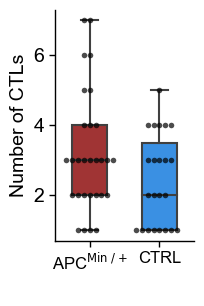

In [11]:
# Define font
plt.rc('font',family='Arial')

# Plot
fig, ax = plt.subplots(1, figsize = (1.8,3))

order = ['apc', 'wt']

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.tick_params(axis='x', labelsize=12, rotation=0)
ax.tick_params(axis='y', labelsize=14)        
ax.tick_params(width=1, length=4)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1)

sns.boxplot(ax = ax,
            data=caspase_nucleation_all,
            x = 'type',
            y='nb_CTLs_50mu',
            order = order,
            width = 0.5,
            palette = ['firebrick', 'dodgerblue'] ,
           )

sns.swarmplot(data=caspase_nucleation_all,
              x = 'type',
              y='nb_CTLs_50mu',
              color = 'k',
              dodge = True,
              size=4,
              alpha = 0.7,
              order = order,
             )

ax.set_ylabel('Number of CTLs', fontsize=14)
ax.set_xlabel(' ', fontsize=14)
labels = [r'APC$^{\mathrm{Min}\ /+}$', 'CTRL']
ax.set_xticklabels(labels, fontsize=12)
plt.show()

# EP before cascade of killing

In [12]:
apc_P_aligned_to_cas=algin_P_to_cas(caspase_nucleation[caspase_nucleation.type=='apc'],EP_apc,100,50)
wt_P_aligned_to_cas=algin_P_to_cas(caspase_nucleation[caspase_nucleation.type=='wt'],EP_wt,100,50)

apc_P_aligned_to_cas['time'] *= -1
wt_P_aligned_to_cas['time'] *= -1

mean_d_apc=apc_P_aligned_to_cas.groupby(by=['time_f']).EP.mean()
std_d_apc=apc_P_aligned_to_cas.groupby(by=['time_f']).EP.std()/np.sqrt(apc_P_aligned_to_cas.groupby(by=['time_f']).EP.count())

mean_d_wt=wt_P_aligned_to_cas.groupby(by=['time_f']).EP.mean()
std_d_wt=wt_P_aligned_to_cas.groupby(by=['time_f']).EP.std()/np.sqrt(wt_P_aligned_to_cas.groupby(by=['time_f']).EP.count())

ep_apc = apc_P_aligned_to_cas[['EP', 'time']]
ep_apc['type'] = 'apc'
ep_wt = wt_P_aligned_to_cas[['EP', 'time']]
ep_wt['type'] = 'wt'
ep = pandas.concat([ep_apc, ep_wt]).reset_index(drop = True)

C:\Users\vabonnet\AppData\Local\miniconda3\envs\APC\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\vabonnet\AppData\Local\miniconda3\envs\APC\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


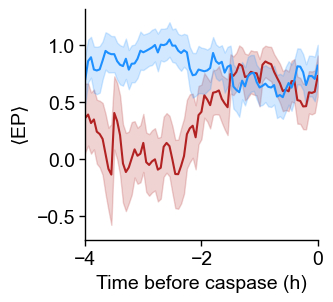

In [13]:
# Define font
plt.rc('font',family='Arial')

# Plot
fig, ax = plt.subplots(1, figsize = (3,3))

order = ['apc', 'wt']

ax.set_xlim(-4,0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.tick_params(axis='x', labelsize=14, rotation=0)
ax.tick_params(axis='y', labelsize=14)        
ax.tick_params(width=1, length=4)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1)

sns.lineplot(ax = ax,
    data = ep,
    x = 'time',
    y = 'EP',
    hue = 'type',
    palette = ['firebrick', 'dodgerblue'],
    errorbar = 'se',    
)

ax.set_xlabel('Time before caspase (h)', fontsize = 14)
ax.set_ylabel(r'$\langle$EP$\rangle$', fontsize = 14)
ax.get_legend().remove()
plt.show()